In [92]:
# !pip install transformers --quiet
# !pip install datasets --quiet
# !pip install torch --quiet
# !nvidia-smi

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import classification_report
import numpy as np
import pandas as pd
import torch

In [94]:
#check the avaialbility of cuda
import torch
torch.cuda.is_available()

False

# 1. Data processing

## a. Mounting, aggregating

- There are 1008 preqs_pairs, pairs of concepts with prerequisite labels

In [95]:
# from google.colab import drive
# drive.mount('/content/drive')
# !ls '/content/drive/MyDrive/thesis/'

import json, csv
from datasets import Dataset, DatasetDict

# File path
preqs_path = './data/cs_preqs.csv'
text_path = './data/cs_courses.csv'
concept_vocab_path = './data/concept_vocab.pkl'
# Read csv file
preqs_pairs = pd.read_csv(preqs_path, sep = ",", names=["concept1", "concept2"])
# remove the underscore from the concept names
preqs_pairs['concept1'] = preqs_pairs['concept1'].str.replace('_', ' ')
preqs_pairs['concept2'] = preqs_pairs['concept2'].str.replace('_', ' ')
preqs_pairs.head(2)



,concept1,concept2
0,Random graph,Mathematics
1,Knowledge representation and reasoning,Algorithm design


### Possible pairing concepts
- Retrieving all the extracted concepts from concept_bow file
- Finding all possible concept pairs ( some pair with label 1, others is assigned label 0)

In [96]:
import pickle

# Open the file in 'read binary' mode
with open(concept_vocab_path, 'rb') as file:
    # Load the data from the file
    concept_vocab = pickle.load(file)

# Now 'data' contains the deserialized Python object
print(concept_vocab)


{24580: 'Lock_(computer_science)', 47129: 'Volume_rendering', 18459: 'Graphical_model', 24606: 'Logic', 18500: 'Graph_(mathematics)', 16454: 'File_system', 47176: 'Vulnerability_(computing)', 6217: 'Cloud_computing', 28748: 'Nonlinear_system', 36942: 'Robot', 34896: 'Quantum_computer', 34898: 'Quantum_cryptography', 34907: 'Quantum_mechanics', 6239: 'Cluster_analysis', 24695: 'Logic_programming', 36989: 'Robotics', 26757: 'ML_(programming_language)', 47238: 'Wavelet', 24715: 'Very_long_instruction_word', 8333: 'Concurrency_control', 26774: 'Mobile_device', 34969: 'Query_language', 30887: 'Perl', 28840: 'NP-complete', 34985: 'Query_optimization', 8364: 'Concurrency_(computer_science)', 42014: 'Symmetric_multiprocessing', 35007: 'Question_answering', 16580: 'Finite_difference', 47305: 'Web_browser', 16587: 'Finite_element_method', 16595: 'Finite-state_machine', 30933: 'Personal_computer', 8408: 'Conditional_probability', 26842: 'Model_checking', 22752: 'Java_(programming_language)', 4734

- extracting all the concepts in the concept vocab list.
  - len(concepts_list) = 345, there are total 345 extracted concepts
  - created concepts_list and concepts_list_idx (maybe for future use)
- find all possible pairs
  - there are 118680 pairs, considering the order of the two elements (concepts)

In [97]:
# extracting all the concepts in the concept vocab list
print(type(concept_vocab))
# print(type(text_dicts))
concepts_list = [] # list of concepts
concepts_list_idx = [] #list of concepts and concepts' ID
for key, value in concept_vocab.items():
  concepts_list_idx.append([key, value])
  concepts_list.append(value)
print(concepts_list[1])
# print(concepts_list_idx[2])

<class 'dict'>
Volume_rendering


In [98]:
#Finding all possible pairs
from itertools import permutations

all_pairs = list(permutations(concepts_list, 2)) #all possible pairs, considering the order of the two elements
len(all_pairs) # there are 118680 possible pairs of concepts

#remove all underscore from the concept names
all_pairs = [list(pair) for pair in all_pairs]
for pair in all_pairs:
  pair[0] = pair[0].replace('_', ' ')
  pair[1] = pair[1].replace('_', ' ')
all_pairs[:10]

[['Lock (computer science)', 'Volume rendering'],
 ['Lock (computer science)', 'Graphical model'],
 ['Lock (computer science)', 'Logic'],
 ['Lock (computer science)', 'Graph (mathematics)'],
 ['Lock (computer science)', 'File system'],
 ['Lock (computer science)', 'Vulnerability (computing)'],
 ['Lock (computer science)', 'Cloud computing'],
 ['Lock (computer science)', 'Nonlinear system'],
 ['Lock (computer science)', 'Robot'],
 ['Lock (computer science)', 'Quantum computer']]

## Labelling all possible pairs
- Labelling for all possible pairing concepts
  - Finding the set ``left_only_df`` includes all pairs in all_pairs and not in ``preqs_pairs``
  - Merging 2 dfs ``left_only_df`` and ``preqs_pairs``
  - Assigning label 0 for set ``left_only_df`` and label 1 for  ``preqs_pairs``

In [99]:
# Finding the set ``left_only_df`` includes all pairs in all_pairs and not in ``preqs_pairs``
import pandas as pd

preqs_pairs_df = pd.DataFrame(preqs_pairs)
# Convert list to a DataFrame for easier comparison
all_pairs_df = pd.DataFrame(all_pairs, columns=['concept1', 'concept2'])

# ----
A = all_pairs_df
B = preqs_pairs_df
# Merge A and B with an indicator flag
merged_df = A.merge(B, on=['concept1', 'concept2'], how='outer', indicator=True)

# Filter out the rows that are only in A (not in B)
# merged_df['_merge'].unique() == ['left_only', 'both', 'right_only'] IS TRUE
both_df = merged_df[merged_df['_merge'] == 'both']
left_only_df = merged_df[merged_df['_merge'] == 'left_only']
right_only_df = merged_df[merged_df['_merge'] == 'right_only']

# Drop the indicator column as it's no longer needed
both_df = both_df.drop(columns=['_merge'])
left_only_df = left_only_df.drop(columns=['_merge'])
right_only_df = right_only_df.drop(columns=['_merge'])

# The resulting difference_df contains elements that are in A but not in B
print(len(both_df)) # label =1
print(len(right_only_df)) # label =1
print(len(left_only_df)) # label = 0

833
175
117848


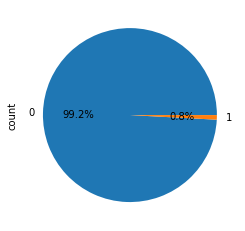

In [100]:
import matplotlib.pyplot as plt

# Merging two dfs and adding idx, labels
left_only_df['label'] = 0
preqs_pairs['label'] = 1

# Merging the DataFrames
data_df = pd.merge(left_only_df, preqs_pairs, how='outer')

# Resetting the index of the merged DataFrame
data_df.reset_index(drop=True, inplace=True)

# Plotting the distribution of the labels
data_df['label'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.show()

# # Number of value counts
# data_df['label'].value_counts()


In [1]:
len(data_df)

NameError: name 'data_df' is not defined

## Sampling >> final dataset
We have two dfs here, preq(+) is ``preqs_pairs`` and preq(-) is ``left_only_df``
 - Split train/dev/test of ``preqs_pairs``
 - Oversampling for the preq (+) with 1.5 times only on the ``train`` set
 - Negative sampling for the preq (-) = the number of  the preq (+)

### Base dataset

In [105]:
#data-based splitting
# SPLITTING the preqs_pairs into train, dev, and test sets 70%, 10%, 20%
train = preqs_pairs.sample(frac=0.7, random_state=42)
preqs_pairs_dev = preqs_pairs.drop(train.index).sample(frac=0.33333333, random_state=42) # sampling 1/3 of the remaining data
preqs_pairs_test = preqs_pairs.drop(train.index).drop(preqs_pairs_dev.index)

# OVERSAMPLING from the train set where the label is 1
n = int(0.5*len(train))
rows_to_oversample = train.sample(n, replace=True)

# Concatenating the train set and the oversampled rows to create the new train set
preqs_pairs_train = pd.concat([train, rows_to_oversample])

# Reset the index of the oversampled dataframe
preqs_pairs_train.reset_index(drop=True, inplace=True) # label 1


# NEGATIVE SAMPLING from the left_only_df where the label is 0

# split the negative_samples into train, dev, and test sets
negative_samples_train = left_only_df.sample(int(len(preqs_pairs_train)), random_state=42) #same size as preqs_pairs_train
negative_samples_dev = left_only_df.drop(negative_samples_train.index).sample(len(preqs_pairs_dev), random_state=42)
negative_samples_test = left_only_df.drop(negative_samples_train.index).drop(negative_samples_dev.index).sample(len(preqs_pairs_test), random_state=42)

# MERGING the oversampled_df and negative_samples and suffling the data
data_train = pd.concat([preqs_pairs_train, negative_samples_train])
data_dev = pd.concat([preqs_pairs_dev, negative_samples_dev])
data_test = pd.concat([preqs_pairs_test, negative_samples_test])
# suffling the data
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_dev = data_dev.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)

#
data_train.to_csv('./data/data-base/data_train.csv', index=False)
data_test.to_csv('./data//data-base/data_test.csv', index=False)
data_dev.to_csv('./data/data-base/data_dev.csv', index=False)

### Fewshot dataset
data-zeroshot + data-fewshot + data-base

In [117]:
#data-zeroshot splitting 7/3 and data-fewshot splitting 7/3 and 100 samples,
# test is 30% of the whole non-sampling data, trained on 70% of the data and then oversampling to the ratio of .5
# SPLITTING the preqs_pairs into train, dev, and test sets
sample = preqs_pairs.sample(n=100, random_state=42) # sample 100 rows for few-shot learning
a = int(0.3*len(preqs_pairs)) #test set is 30% of the whole non-sampling data)
preqs_pairs_test = preqs_pairs.drop(sample.index).sample(n=a, random_state=42)
train = preqs_pairs.drop(preqs_pairs_test.index).drop(sample.index)

# OVERSAMPLING from the train set where the label is 1
n = int(0.5*len(train))
rows_to_oversample = train.sample(n, replace=True)

# Concatenating the train set and the oversampled rows to create the new train set
preqs_pairs_train = pd.concat([train, rows_to_oversample])

# Reset the index of the oversampled dataframe
preqs_pairs_train.reset_index(drop=True, inplace=True) # label 1


# NEGATIVE SAMPLING from the left_only_df where the label is 0

# split the negative_samples into train, dev, and test sets
negative_samples_train = left_only_df.sample(int(len(preqs_pairs_train)), random_state=42) #same size as preqs_pairs_train
negative_samples_test = left_only_df.drop(negative_samples_train.index).sample(len(preqs_pairs_test), random_state=42)
negative_samples_sample = left_only_df.drop(negative_samples_train.index).drop(negative_samples_test.index).sample(len(sample), random_state=42)

# MERGING the oversampled_df and negative_samples and suffling the data
data_train = pd.concat([preqs_pairs_train, negative_samples_train])
data_test = pd.concat([preqs_pairs_test, negative_samples_test])
data_sample = pd.concat([sample, negative_samples_sample])
# suffling the data
data_train = data_train.sample(frac=1).reset_index(drop=True)
data_test = data_test.sample(frac=1).reset_index(drop=True)
data_sample = data_sample.sample(frac=1).reset_index(drop=True)


# Exporting the data to csv files
data_train.to_csv('./data/data-fewshot/data_train.csv', index=False)
data_test.to_csv('./data//data-fewshot/data_test.csv', index=False)
data_sample.to_csv('./data/data-fewshot/sample.csv', index=False)

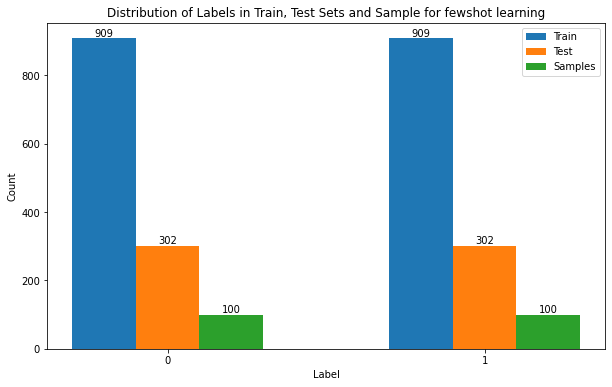

In [118]:
import matplotlib.pyplot as plt

# Calculate the label distribution in each set
train_label_counts = data_train['label'].value_counts()
test_label_counts = data_test['label'].value_counts()
sample_label_counts = data_sample['label'].value_counts()

# Define the x-axis positions for the bars
x = ['0', '1']
# Define the width of the bars
width = 0.2

# Plotting the distribution of the labels
plt.figure(figsize=(10, 6))
train_bars = plt.bar([i - width for i in range(len(x))], [train_label_counts[0], train_label_counts[1]], width=width, label='Train')
test_bars = plt.bar([i for i in range(len(x))], [test_label_counts[0], test_label_counts[1]], width=width, label='Test')
sample_bars = plt.bar([i + width for i in range(len(x))], [sample_label_counts[0], sample_label_counts[1]], width=width, label='Samples')
# Function to add counts on top of bars
def add_counts(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, height, ha='center', va='bottom')

add_counts(train_bars)
add_counts(test_bars)
add_counts(sample_bars)

plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Distribution of Labels in Train, Test Sets and Sample for fewshot learning')
plt.xticks(range(len(x)), x)
plt.legend()

# Save the figure to the data file
plt.savefig('./data/data-fewshot/label_distribution.png')
plt.show()


In [106]:
data_sample

,concept1,concept2,label
0,Parsing,Algorithm design,1
1,Software testing,Programming language,1
2,Message Passing Interface,Synchronization,1
3,Automated theorem proving,Logic programming,0
4,Shared memory,String (computer science),0
5,Internet Protocol Suite,Computer,1
6,Graphical user interface,Interactivity,0
7,Sparse matrix,Mathematics,0
8,Robotics,Kinematics,1
9,Hidden Markov model,Computational complexity theory,0


## b. Dict

### Pairs to dict


In [ ]:
# df to dict
def df_to_dict(df):
    data_dicts = []
    for idx, row in df.iterrows():  # Use iterrows for DataFrame iteration
        concept1, concept2, label = row['concept1'], row['concept2'], row['label'] # Access columns correctly
        data_dicts.append({
            'concept1': concept1,
            'concept2': concept2,
            'idx': idx,
            'label': label
        })
    return data_dicts
data_dicts = df_to_dict(data_df)

In [ ]:
from datasets import load_dataset
from openprompt.data_utils import InputExample
from transformers import  AdamW, get_linear_schedule_with_warmup
from openprompt.prompts import MixedTemplate
from openprompt import PromptDataLoader
from openprompt import PromptForClassification
from openprompt.prompts import ManualVerbalizer
import torch
from pprint import pprint
from openprompt.plms import load_plm

/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v5. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(


In [ ]:
# split data
from sklearn.model_selection import train_test_split

# Splitting the data into train, validation, and test sets (60%, 20%, 20%)
train, temp = train_test_split(data_dicts, test_size=0.4, random_state=42, shuffle=True)
val, test = train_test_split(temp, test_size=0.5, random_state=42, shuffle=True)

# Checking the size of each set
len(train), len(val), len(test)
# Preparing the shuffled result dictionary

data_dicts_split = {
    'train': train,
    'validation': val,
    'test': test
}

# print(len(data_dicts_split['train']))
# print(len(data_dicts_split['validation']))
# print(len(data_dicts_split['test']))

In [ ]:
# data_dicts_split to dataset (read-to-use one)
datasetnetworkx as nx
i port m= {}
for split in ['train', 'validation', 'test']:
    dataset[sp10 learning concepts that appear most frequently in preqs_pairs['concept1']
import matplotlib.pyplot as plt

# Get the top lit] = []
    for data in data_dicts_split[split]:
        input_example = InputExample(text_a = data['concept1'], text_b = data['concept2'], label=int(data['label']), guid=int(data['idx']))
        dataset[split].append(input_example)
print(dataset['train'][0])]')
plt.axis('off')
plt.show()

# Create a new dataframe with only the top concepts
top_concepts_df = preqs_pairs[preqs_pairs['concept2'].isin(top_concepts)]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(top_concepts, color='green')
G.add_nodes_from(top_concepts_df['concept2'].unique(), color='orange')

# Add edges to the graph
for _, row in top_concepts_df.iterrows():
    G.add_edge(row['concept2', row['concept1'])#, label=row['label'])

# Set node colors
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# Draw the network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=4000, font_size=8, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
plt.title('The Top Fundamental Learning Concepts in the Dataset

{
  "guid": 84108,
  "label": 0,
  "meta": {},
  "text_a": "Interpolation",
  "text_b": "Internet",
  "tgt_text": null
}



## Network of preqs_pairs

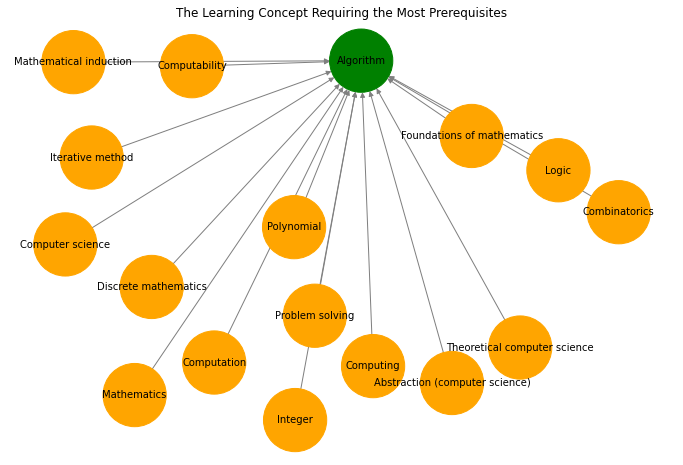

In [155]:
import networkx as nx
import matplotlib.pyplot as plt

# Get the top 10 learning concepts that appear most frequently in preqs_pairs['concept1']
top_concepts = preqs_pairs['concept1'].value_counts().nlargest(1).index.tolist()

# Create a new dataframe with only the top concepts
top_concepts_df = preqs_pairs[preqs_pairs['concept1'].isin(top_concepts)]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(top_concepts, color='green')
G.add_nodes_from(top_concepts_df['concept2'].unique(), color='orange')

# Add edges to the graph
for _, row in top_concepts_df.iterrows():
    G.add_edge(row['concept2'], row['concept1'])#, label=row['label'])

# Set node colors
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# Draw the network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(12, 8))
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=4000, font_size=10, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='black')
plt.title('The Learning Concept Requiring the Most Prerequisites')
plt.axis('off')
plt.show()

#orange: concept 2, green, concept 1

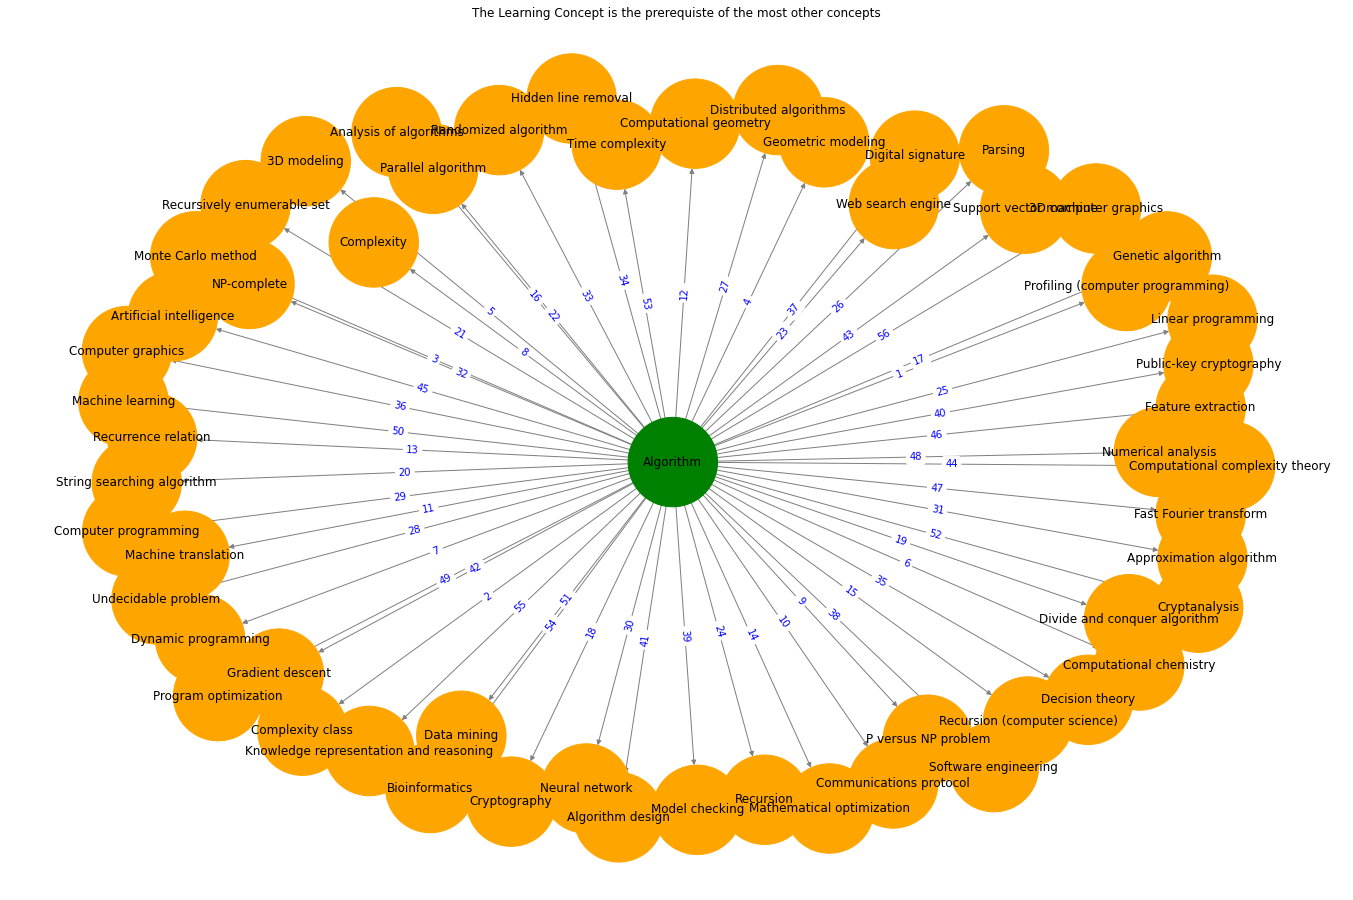

In [161]:
import networkx as nx
import matplotlib.pyplot as plt

top_concepts = preqs_pairs['concept2'].value_counts().nlargest(3).index.tolist()[1:2]
# top_concepts = preqs_pairs['concept2'].value_counts().nlargest(2).index.tolist()

# Create a new dataframe with only the top concepts
top_concepts_df = preqs_pairs[preqs_pairs['concept2'].isin(top_concepts)]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
G.add_nodes_from(top_concepts, color='green')
G.add_nodes_from(top_concepts_df['concept1'].unique(), color='orange')

# Add edges to the graph
for idx, (_, row) in enumerate(top_concepts_df.iterrows()):
    G.add_edge(row['concept2'], row['concept1'], label=idx+1)

# Set node colors
node_colors = [G.nodes[node]['color'] for node in G.nodes]

# Draw the network
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(24, 16))
nx.draw_networkx(G, pos, with_labels=True, node_color=node_colors, node_size=8000, font_size=12, edge_color='gray')
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_color='blue')
plt.title('The Learning Concept is the prerequiste of the most other concepts')
plt.axis('off')
plt.show()
